### Ejercicio de Regresión 

### Predicción del precio de diamantes

El objetivo del ejercicio es crear un modelo de regresión para predecir el precio de diamantes, a partir de un dataset con diferentes características de los mismos.

La métrica sobre la que evaluaremos el modelo será el RMSE, con la que evaluaremos nuestro error a la hora de predecir el precio del diamante.

**Descripción del Dataset**

*Columnas*
+ carat:	peso del diamante (quilates)

+ cut:	calidad del corte (Fair, Ideal, Good, Very Good, Premium)

+ color: color (D (mejor) a J (peor))

+ clarity: claridad (I1 (peor), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (mejor)) 

+ table: ancho del corte superior del diamante

+ x: largo en mm

+ y: ancho en mm

+ z: alto en mm

+ depth:	2*z/(x+y)

+ price:	precio en dolares USA


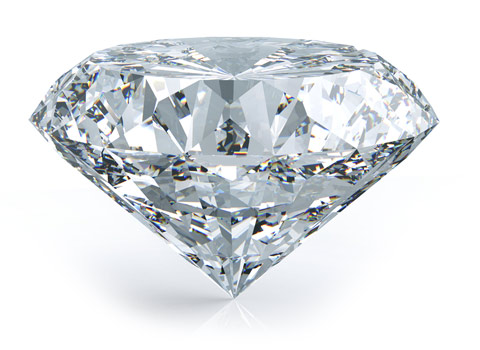

**Pasos que debemos seguir a la hora de realizar el modelo**

- EDA. Realizar un análisis exploratorio de los datos, realizar gráficos que sean necesarios que nos ayuden a entender cual es el estado de nuestros datos, como se distribuyen, si hay muchos nulos, outliers, matriz de correlación, etc.

- División train-test.

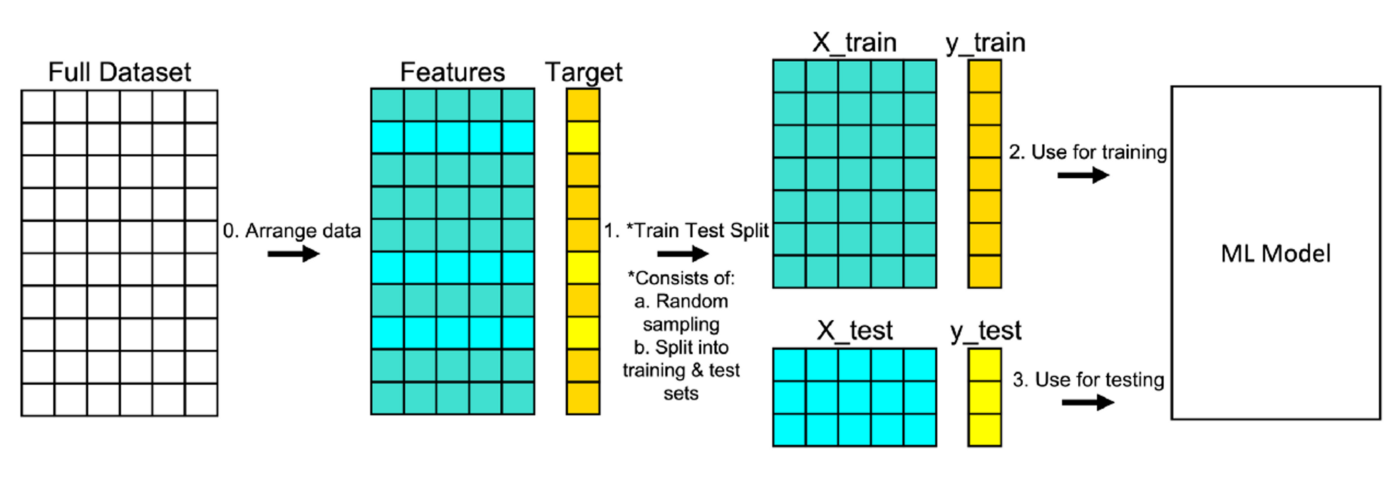

- Una vez terminado nuestro análisis exploratorio, deberemos realizar las transformaciones necesarias de las columnas categóricas que creamos que pueden ser buenas predictoras para nuestro modelo.

- Una vez tengamos los datos preparados ya podemos pasar al siguiente paso, entrenar diferentes tipos de modelos.

- Evaluar los diferentes modelos entrenados.

- Seleccionar el modelo finalista

### Librerías

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Transformaciones de datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Modelos

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

# Métricas para Regresión
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Datos

In [163]:
df_diamonds = pd.read_csv('../Data/diamonds.csv')
df_diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95


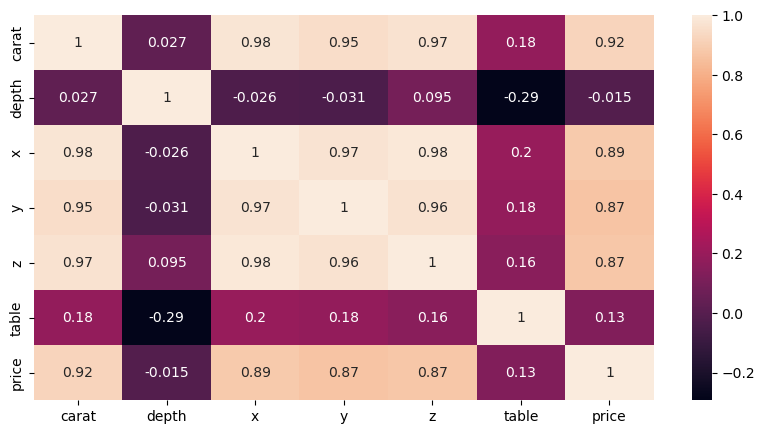

In [164]:
plt.figure(figsize = (10, 5))
sns.heatmap(data = df_diamonds[["carat", "depth", "x", "y", "z", "table", "price"]].corr(), annot = True)
plt.show()

In [4]:
df_diamonds.shape

(40455, 10)

<Axes: xlabel='price', ylabel='Count'>

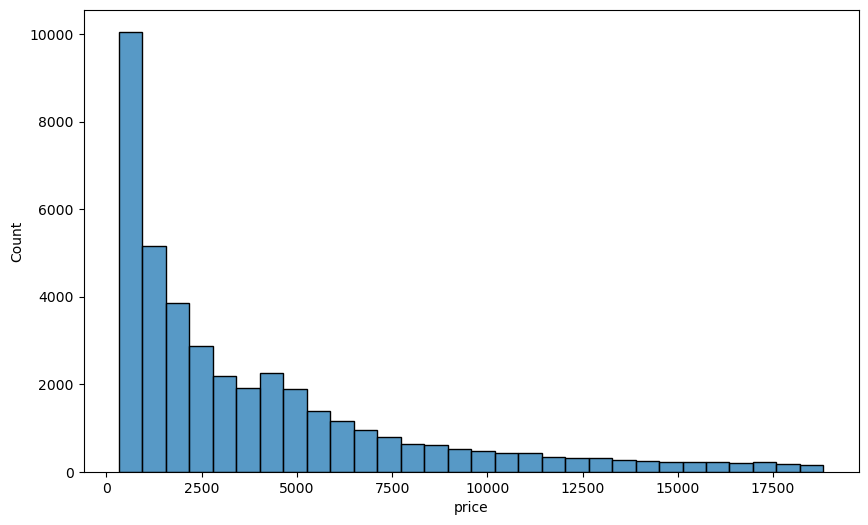

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df_diamonds["price"], bins = 30)

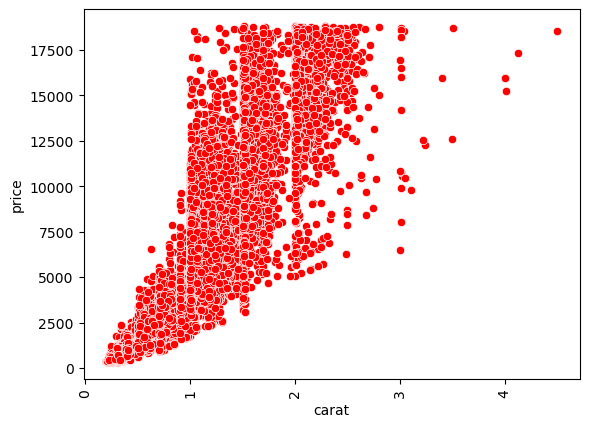

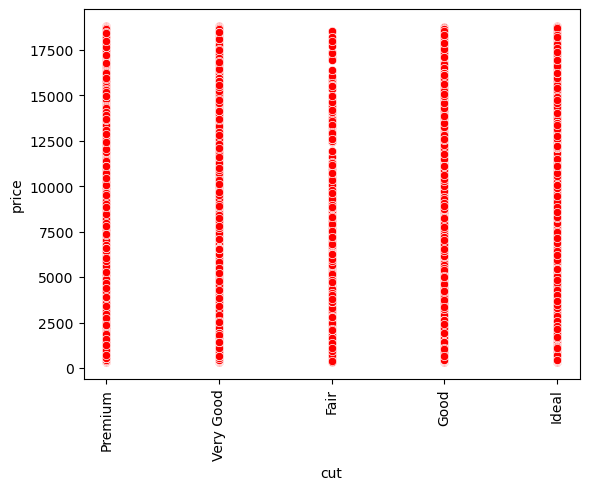

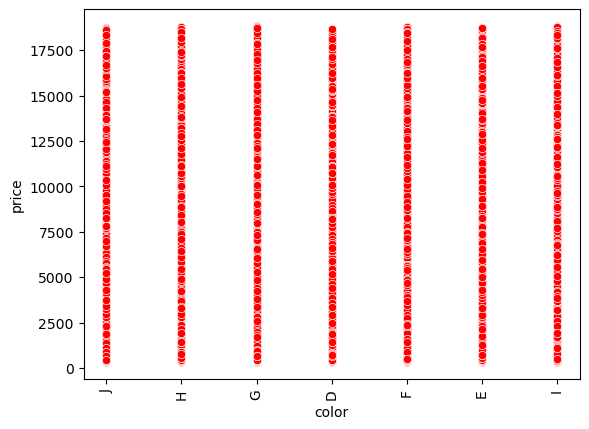

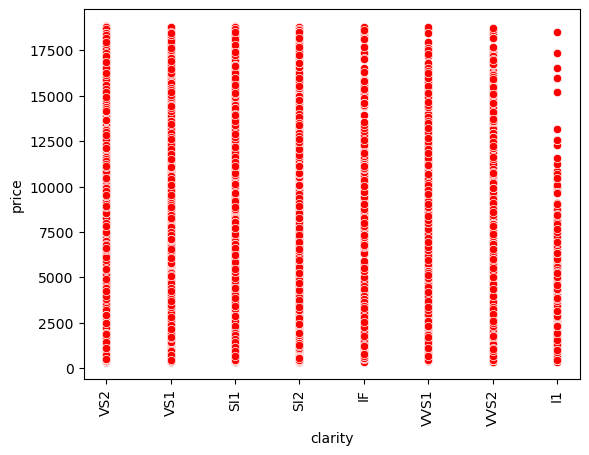

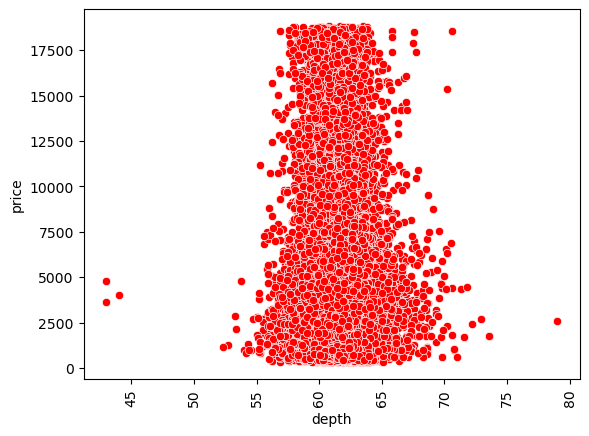

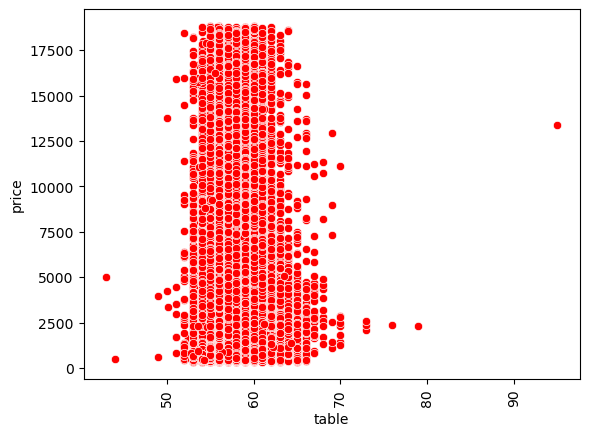

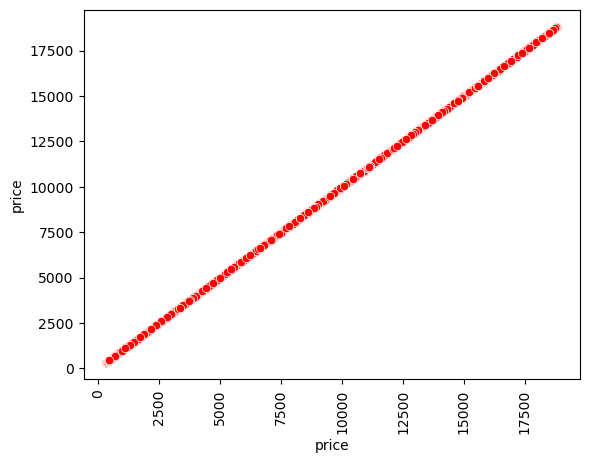

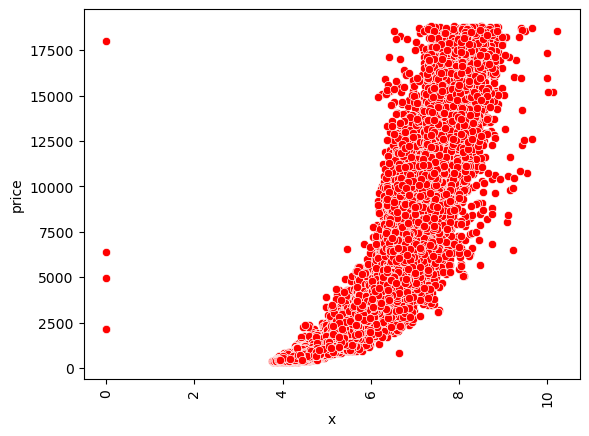

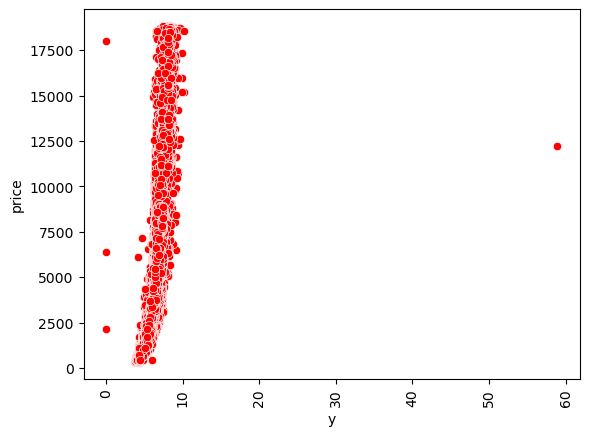

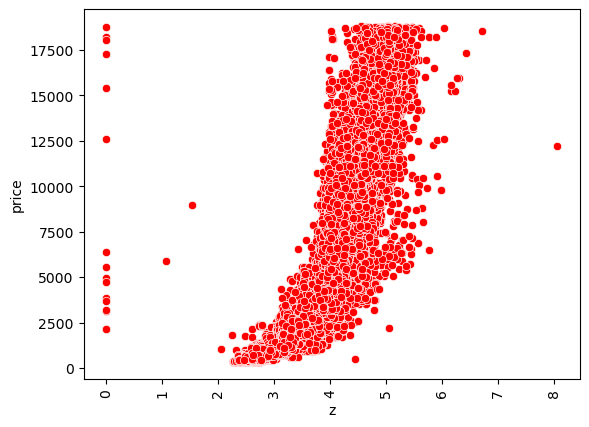

In [4]:
for col in df_diamonds.columns:
    sns.scatterplot(x = df_diamonds[col], y = df_diamonds["price"], color = "r")
    plt.xticks(rotation=90)
    plt.show()

### **PROCESAMIENTO DE DATOS**

In [141]:
df_diamonds = pd.read_csv('../Data/diamonds.csv')

In [142]:
backup = df_diamonds.copy()

**COLUMNAS NUMÉRICAS**

In [165]:
# HAY DIAMANTES QUE MIDEN 0 DE ALTO, DE ANCHO Y DE LARGO, o que dos de esos datos no se conocen
# LOS VAMOS A ELIMINAR:
df_diamonds = df_diamonds.drop(df_diamonds[
    ((df_diamonds["x"] == 0) & (df_diamonds["z"] == 0)) |
    ((df_diamonds["x"] == 0) & (df_diamonds["y"] == 0)) |
    ((df_diamonds["y"] == 0) & (df_diamonds["z"] == 0))
].index)

In [170]:
df_diamonds[df_diamonds["y"] > 11]

,carat,cut,color,clarity,depth,table,price,x,y,z
14708,2.0,Premium,H,SI2,58.9,57.0,12210,8.09,58.9,8.06


In [144]:
# HAY VARIOS DIAMANTES A LOS QUE LE FALTA la z:
def despejar_z(x, y, depth):
    z = (depth * (x + y)) / 2
    return z
def despejar_y(x, z, depth):
    y = (2 * z / depth) - x
    return y

In [169]:
indices_z_0 = df_diamonds[df_diamonds['z'] == 0].index.to_list()
for i in indices_z_0:
    x = df_diamonds.loc[i, "x"]
    y = df_diamonds.loc[i, "y"]
    depth = df_diamonds.loc[i, "depth"]
    z = despejar_z(x, y, depth)
    df_diamonds.loc[i, "z"] = z

La medida más común para describir el tamaño de un diamante es en **quilates (carats)**, donde 1 quilate es equivalente a 0.2 gramos. Los diamantes utilizados en joyería son considerablemente más pequeños que 6 centímetros. 

**El Cullinan I (Estrella del Sur): Es el diamante más grande jamás encontrado y pesa alrededor de 3,106 quilates (aproximadamente 621 gramos)**. Fue cortado en varios diamantes más pequeños, y el Cullinan I es el diamante más grande, con alrededor de 530.2 quilates (aproximadamente 106 gramos). **El Golden Jubilee: Este diamante pesa aproximadamente 545.67 quilates (alrededor de 109 gramos)**. Fue cortado en 1997 y es conocido por su color marrón. En la **joyería cotidiana**, los diamantes son mucho más pequeños. En anillos de compromiso, por ejemplo, los diamantes suelen tener tamaños que van desde menos de un quilate hasta varios quilates, pero rara vez superan los **5 quilates.**

**Longitud:** En anillos de compromiso y joyería de uso diario, los diamantes suelen tener longitudes que van desde aproximadamente **5 mm hasta 10 mm.**

**Ancho:** El ancho de un diamante en joyería cotidiana varía según la forma y el estilo de talla. Por ejemplo, un diamante redondo puede tener un ancho similar a su longitud, mientras que un diamante cuadrado o rectangular (como el corte princesa o esmeralda) puede tener un ancho ligeramente menor. Los anchos suelen estar en el rango de **5 mm a 10 mm** para joyería de uso diario.

**Altura (Profundidad):** La altura de un diamante, o su profundidad, depende de la forma y el estilo de talla. Las piedras preciosas suelen tener alturas que van desde alrededor del **50% al 70%** de su **diámetro o longitud**. En términos de milímetros, esto podría traducirse en alturas de aproximadamente **3 mm a 7 mm** para un diamante redondo de 6 mm de diámetro.

In [171]:
indices_y_grande = df_diamonds[df_diamonds['y'] > 11].index.to_list()
for i in indices_y_grande:
    x = df_diamonds.loc[i, "x"]
    z = df_diamonds.loc[i, "z"]
    depth = df_diamonds.loc[i, "depth"]
    y = despejar_z(x, z, depth)
    df_diamonds.loc[i, "y"] = y

In [172]:
df_diamonds.shape

(40450, 10)

In [173]:
# HAY VALORES MUY ALTOS AÚN DESPUES DE HABERLES APLICADO LA FÓRMULA, LO QUEME SUJIERE QUE ESTÁN MAL
# z < 70% de x
# y < 11
# x < 11

filtro_z = (df_diamonds["z"] > ((7*df_diamonds["x"])/10))
filtro_y = (df_diamonds["y"] > 11)
filtro_x = (df_diamonds["x"] > 11)
df_diamonds = df_diamonds.drop(df_diamonds[filtro_z | filtro_y | filtro_x].index)

In [174]:
df_diamonds.shape

(40422, 10)

**COLUMNAS CATEGÓRICAS**

In [175]:
def transformaciones_col_categ(df:pd.DataFrame, cols:list, target:str):
    for c in cols:
        
        dictio = df.groupby(c).agg({target:'mean'})
        dictio.reset_index(inplace=True)
        dictio = dict(zip(dictio[c],dictio[target]))
        df[c] = df[c].apply(lambda x: dictio[x])
  
    return df

In [176]:
df_diamonds = transformaciones_col_categ(df_diamonds, ["color", "cut", "clarity"], "price")

In [180]:
df_diamonds.sort_values("color", ascending=False)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,4610.729703,5347.897148,3912.009951,62.4,58.0,4268,6.83,6.79,4.25
21017,1.25,3435.887779,5347.897148,3240.978942,61.1,57.0,6084,6.94,6.91,4.23
2914,0.53,3435.887779,5347.897148,3796.278859,61.4,55.2,1218,5.20,5.22,3.20
22019,1.41,3435.887779,5347.897148,3796.278859,61.6,56.0,8275,7.19,7.22,4.44
22007,0.37,3435.887779,5347.897148,3996.298851,60.5,57.0,497,4.63,4.66,2.81
...,...,...,...,...,...,...,...,...,...,...
25993,1.02,3435.887779,3088.412070,2559.635413,61.3,57.0,11128,6.47,6.54,3.99
14308,0.32,3435.887779,3088.412070,3240.978942,62.3,55.0,890,4.37,4.40,2.73
14305,1.01,4332.673317,3088.412070,5096.662328,67.6,57.0,2862,6.21,6.11,4.18
32979,0.38,3994.643941,3088.412070,3796.278859,61.5,58.0,1000,4.64,4.69,2.87


In [177]:
df_diamonds.reset_index(drop=True)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,4610.729703,5347.897148,3912.009951,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,3994.643941,4467.677517,3912.009951,63.0,57.0,505,4.35,4.38,2.75
2,0.71,4332.673317,4018.970985,3796.278859,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,3877.262093,3134.978007,3996.298851,63.8,56.0,738,4.68,4.72,3.00
4,1.02,3435.887779,4018.970985,3996.298851,60.5,59.0,4882,6.55,6.51,3.95
...,...,...,...,...,...,...,...,...,...,...
40417,1.34,3435.887779,4018.970985,3796.278859,62.7,57.0,10070,7.10,7.04,4.43
40418,2.02,3877.262093,3678.388788,5096.662328,57.1,60.0,12615,8.31,8.25,4.73
40419,1.01,3435.887779,4467.677517,3996.298851,62.7,56.0,5457,6.37,6.42,4.01
40420,0.33,3435.887779,5347.897148,3796.278859,61.9,54.3,456,4.45,4.47,2.76


### **CORRELACIONES**

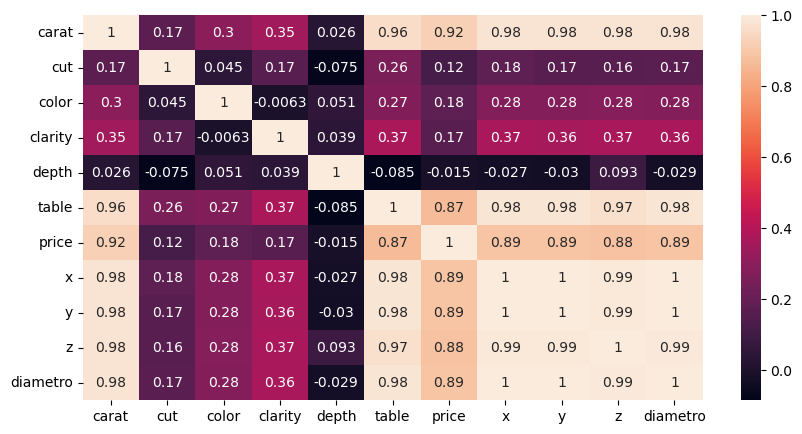

In [198]:
plt.figure(figsize = (10, 5))
sns.heatmap(data = df_diamonds.corr(), annot = True)
plt.show()

In [59]:
df_diamonds.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z', 'diametro'],
      dtype='object')

### **ÚLTIMO FILTRADO DESPUÉS DE HABER PROBADO EL MODELO CON TODO LO DE ARRIBA, SALE UN RMSE DE 1278 DOLARES, VAMOS A VER SI BAJA**

In [183]:
# CREANDO COLUMNA DIAMETRO DEL DIAMANTE:
df_diamonds["diametro"] = (df_diamonds["x"] + df_diamonds["y"]) / 2

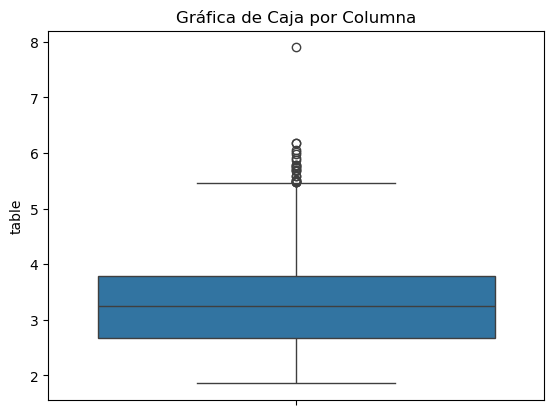

In [185]:
sns.boxplot(data=df_diamonds.table)
plt.title('Gráfica de Caja por Columna')
plt.show()

In [184]:
# LA COLUMNA TABLE ES UN PORCENTAJE
df_diamonds['table'] = (df_diamonds['table'] / 100) * df_diamonds['diametro']

Quilataje (carat): El quilataje es la medida del peso de un diamante. En general, cuanto mayor es el quilataje, mayor es el precio, ya que los diamantes más grandes son más raros.

Corte (cut): El corte se refiere a la calidad del trabajo de tallado y a la forma en que un diamante refleja la luz. Un buen corte puede realzar la belleza y el brillo de un diamante, lo que puede influir en su valor.

Color (color): Los diamantes con menos color son generalmente más valiosos. La escala de color va desde D (sin color) hasta Z (color ligero).

Claridad (clarity): La claridad se refiere a la presencia de imperfecciones o inclusiones en un diamante. Diamantes con menos imperfecciones tienden a tener un mayor valor.

## **NO ------------------------------------------------------------------ NO**

In [131]:
len(df_diamonds[(df_diamonds["price"] > 12500)].index.to_list())

2343

In [132]:
df_diamonds[(df_diamonds["price"] > 12500)][["price", "color"]].sort_values("price", ascending=False)

,price,color
7034,18823,5090.868800
3990,18818,4023.214902
29107,18806,4023.214902
25529,18797,5090.868800
6912,18795,4476.469014
...,...,...
30039,12522,4023.214902
34692,12521,4023.214902
22196,12509,5090.868800
23531,12508,4023.214902


In [133]:
# Calcular la media del precio para cada color
mean_price_by_color = df_diamonds.groupby('color')['price'].mean()

# Llenar los valores faltantes en la columna 'price' que son mayores a 12500 con la media según el color
df_diamonds.loc[(df_diamonds['price'] > 12500), 'price'] = df_diamonds.loc[(df_diamonds['price'] > 12500), 'color'].map(mean_price_by_color)

C:\Users\Ane Zubieta\AppData\Local\Temp\ipykernel_13724\2786387880.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4023.21490242 4023.21490242 5090.8687996  ... 4476.46901386 4476.46901386
 3677.35571966]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_diamonds.loc[(df_diamonds['price'] > 12500), 'price'] = df_diamonds.loc[(df_diamonds['price'] > 12500), 'color'].map(mean_price_by_color)


In [135]:
df_diamonds = df_diamonds.drop(df_diamonds[(df_diamonds["table"] > 5.5)].index)

## **SI --------------------------------------------------------------- SI**

### **ENTRENAMIENTO MODELO REGRESIÓN Y PREDICCIONES**

In [238]:
X = np.array(df_diamonds[["carat", "table", "x", "y", "z", "color", "clarity", "diametro"]])

y = np.array(df_diamonds["price"])

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 42)

print(f"Conjunto de Train: {X_train.shape, y_train.shape}")
print(f"Conjunto de Test: {X_test.shape, y_test.shape}")

Conjunto de Train: ((24253, 8), (24253,))
Conjunto de Test: ((16169, 8), (16169,))


In [231]:
# Puedes ajustar los hiperparámetros según tus necesidades
regresion = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
regresion.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [240]:
regresion = KNeighborsRegressor(n_neighbors=4) # EL MEJOR RESULTADO!!
regresion.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=4)

In [241]:
yhat = regresion.predict(X_test)
yhat2 = regresion.predict(X_test)
n = 0
indices = []
for i, j in zip(yhat[:], y_test[:]):
    n += 1
    if np.abs(i-j) > (math.sqrt(mean_squared_error(y_test, yhat))):
        indices.append(n)
        print(f"Predicción:{i} \tValor real:{j} \t {n}")

Predicción:11446.5 	Valor real:12343 	 7
Predicción:5328.25 	Valor real:4654 	 16
Predicción:9269.5 	Valor real:8256 	 32
Predicción:1889.75 	Valor real:949 	 52
Predicción:12795.75 	Valor real:14375 	 53
Predicción:3497.0 	Valor real:4360 	 56
Predicción:4821.25 	Valor real:3951 	 83
Predicción:14702.25 	Valor real:16592 	 87
Predicción:9180.75 	Valor real:10245 	 99
Predicción:3742.0 	Valor real:3091 	 101
Predicción:5428.5 	Valor real:3998 	 102
Predicción:4626.5 	Valor real:5311 	 103
Predicción:5811.0 	Valor real:5028 	 114
Predicción:10414.5 	Valor real:9082 	 121
Predicción:11825.0 	Valor real:12530 	 123
Predicción:17461.25 	Valor real:12907 	 126
Predicción:5425.75 	Valor real:4784 	 127
Predicción:1462.5 	Valor real:2099 	 146
Predicción:7728.25 	Valor real:6803 	 147
Predicción:14018.25 	Valor real:17136 	 152
Predicción:14799.25 	Valor real:15535 	 154
Predicción:4518.5 	Valor real:3297 	 156
Predicción:13180.0 	Valor real:11489 	 160
Predicción:8368.75 	Valor real:10094 	 

In [228]:
for i in indices:
    print(df_diamonds.loc[i, (df_diamonds.columns)])

carat          1.520000
cut         3435.887779
color       5347.897148
clarity     3796.278859
depth         62.300000
table          4.254300
price       8608.000000
x              7.320000
y              7.350000
z              4.570000
diametro       7.335000
Name: 7, dtype: float64
carat          0.430000
cut         3435.887779
color       3134.978007
clarity     3796.278859
depth         62.100000
table          2.721600
price       1207.000000
x              4.850000
y              4.870000
z              3.020000
diametro       4.860000
Name: 16, dtype: float64
carat          0.970000
cut         3435.887779
color       4467.677517
clarity     2559.635413
depth         60.400000
table          3.670800
price       6801.000000
x              6.400000
y              6.480000
z              3.890000
diametro       6.440000
Name: 32, dtype: float64
carat          0.310000
cut         3435.887779
color       5088.490819
clarity     3796.278859
depth         61.300000
table         

### **MÉTRICAS**

In [242]:
# Relative Absolute Error
RAE = np.sum(np.abs(np.subtract(y_test, yhat))) / np.sum(np.abs(np.subtract(y_test, np.mean(y_test))))
# Relative Square Error
RSE = np.sum(np.square(np.subtract(y_test, yhat))) / np.sum(np.square(np.subtract(y_test, np.mean(y_test))))
# Adjusted R**2

r2_ajustada = 1 - (1 - regresion.score(X_test, y_test))*(len(y_test) - 1)/(len(y_test) - X_test.shape[1] - 1)

print(f"MAE:\t {mean_absolute_error(y_test, yhat)}")
print(f"MSE:\t {mean_squared_error(y_test, yhat)}")
print(f"RMSE:\t {math.sqrt(mean_squared_error(y_test, yhat))}")
print(f"R**2:\t {r2_score(y_test, yhat)}")
print(f"RAE:\t {RAE}")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada}")

MAE:	 315.107335023811
MSE:	 377206.46857412334
RMSE:	 614.1713674326762
R**2:	 0.9762300780711447
RAE:	 0.10376973614583324
RSE:	 0.023769921928855246
Adjusted R**2:	 0.9762183107830611


### **NORMALIZANDO  DATOS:**

In [243]:
X = np.array(df_diamonds[["carat", "table", "x", "y", "z", "diametro", "color", "cut", "clarity"]])

y = np.array(df_diamonds["price"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 42)

# Normalizacion de X_train
scaler_x = MinMaxScaler()
scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)

# Normalizacion de y_train
scaler_y = MinMaxScaler()
scaler_y.fit(y_train.reshape(-1, 1)) # .reshape(-1, 1) se utiliza para transformar un vector a una matriz
y_train = scaler_y.transform(y_train.reshape(-1,1))

# Normalizacion de X_test
#scaler_x.fit(X_test)
X_test = scaler_x.transform(X_test)

# Normalizacion de y_test
#scaler_y.fit(y_test.reshape(-1, 1)) # .reshape(-1, 1) se utiliza para transformar un vector a una matriz
y_test = scaler_y.transform(y_test.reshape(-1,1))

print(f"Conjunto de Train: {X_train.shape, y_train.shape}")
print(f"Conjunto de Test: {X_test.shape, y_test.shape}")

Conjunto de Train: ((24253, 9), (24253, 1))
Conjunto de Test: ((16169, 9), (16169, 1))


In [82]:
regresion = RadiusNeighborsRegressor(radius=0.5)
regresion.fit(X_train, y_train)

RadiusNeighborsRegressor(radius=0.5)

In [244]:
regresion = KNeighborsRegressor(n_neighbors=4)
regresion.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=4)

In [245]:
yhat = regresion.predict(X_test)

for i, j in zip(yhat[:5], y_test[:5]):
    print(f"Predicción:{i} \tValor real:{j}")

Predicción:[0.02237454] 	Valor real:[0.01871079]
Predicción:[0.22108209] 	Valor real:[0.45370971]
Predicción:[0.01995457] 	Valor real:[0.01914341]
Predicción:[0.02161746] 	Valor real:[0.02255029]
Predicción:[0.0890385] 	Valor real:[0.09847502]


### **MÉTRICAS** CON DATOS NORMALIZADOS

In [246]:
yhat_natural = scaler_y.inverse_transform(yhat)
ytest_natural = scaler_y.inverse_transform(y_test)

RAE = np.sum(np.abs(np.subtract(ytest_natural, yhat_natural))) / np.sum(np.abs(np.subtract(ytest_natural, np.mean(ytest_natural))))
# Relative Square Error
RSE = np.sum(np.square(np.subtract(ytest_natural, yhat_natural))) / np.sum(np.square(np.subtract(ytest_natural, np.mean(ytest_natural))))
# Adjusted R**2
r2_ajustada = 1 - (1 - regresion.score(X_test, y_test))*(len(y_test) - 1)/(len(y_test) - X_test.shape[1] - 1)

#RAE CHATGPT:
RAE2 = np.sum(np.abs(np.subtract(ytest_natural, yhat_natural))) / np.sum(np.abs(np.subtract(ytest_natural, np.mean(ytest_natural))))

print(f"MAE:\t {mean_absolute_error(ytest_natural, yhat_natural)} Los precios se desvian {(mean_absolute_error(ytest_natural, yhat_natural) / np.mean(ytest_natural))*100} % (magnitud del error en términos porcentuales en relación con la media de los valores reales)")
print(f"MSE:\t {mean_squared_error(ytest_natural, yhat_natural)} Los precios se desvian {(mean_squared_error(ytest_natural, yhat_natural) / np.mean(ytest_natural))*100} % (magnitud del error cuadrático medio en términos porcentuales en relación con la media de los valores reales)")
print(f"RMSE:\t {math.sqrt(mean_squared_error(ytest_natural, yhat_natural))} Los precios se están desviando un {math.sqrt(mean_squared_error(ytest_natural, yhat_natural))*100} % (tiene la misma escala que la variable objetivo, por lo que a menudo se prefiere para la interpretación de errores en modelos de regresión)")
print(f"R**2:\t {r2_score(y_test, yhat)} o {(r2_score(y_test, yhat))*100} % (proporción de variabilidad explicada)")
print(f"RAE:\t {RAE} las predicciones del modelo están desviándose en aproximadamente un {RAE*100} Cuanto más bajo sea el RAE, mejor será el rendimiento del modelo en términos relativos.")
print(f"RAE2:\t {RAE2} las predicciones del modelo están desviándose en aproximadamente un {RAE*100} Cuanto más bajo sea el RAE, mejor será el rendimiento del modelo en términos relativos.")
print(f"RSE:\t {RSE}")
print(f"Adjusted R**2:\t {r2_ajustada} o {(r2_ajustada)*100} %")

MAE:	 368.3176603376832 Los precios se desvian 9.430097613152954 % (magnitud del error en términos porcentuales en relación con la media de los valores reales)
MSE:	 591890.0414721072 Los precios se desvian 15154.25804512817 % (magnitud del error cuadrático medio en términos porcentuales en relación con la media de los valores reales)
RMSE:	 769.3439032527048 Los precios se están desviando un 76934.39032527048 % (tiene la misma escala que la variable objetivo, por lo que a menudo se prefiere para la interpretación de errores en modelos de regresión)
R**2:	 0.9627016468475694 o 96.27016468475695 % (proporción de variabilidad explicada)
RAE:	 0.12129272213927966 las predicciones del modelo están desviándose en aproximadamente un 12.129272213927965 Cuanto más bajo sea el RAE, mejor será el rendimiento del modelo en términos relativos.
RAE2:	 0.12129272213927966 las predicciones del modelo están desviándose en aproximadamente un 12.129272213927965 Cuanto más bajo sea el RAE, mejor será el 

Reducir el Root Mean Squared Error (RMSE) en un modelo de regresión puede ser un desafío, pero hay varias estrategias que puedes considerar para mejorar el rendimiento del modelo. Aquí hay algunas sugerencias:

1. **Feature Engineering:**
   - **Interacción de características:** Considera la posibilidad de crear nuevas características que sean interacciones entre las características existentes. Por ejemplo, podrías multiplicar 'carat' por 'cut' o 'color' para capturar posibles relaciones no lineales.

2. **Normalización o Transformación de Datos:**
   - **Normalización:** Asegúrate de que todas las características estén en la misma escala. Puedes utilizar técnicas de normalización, como escalar las características a un rango específico (por ejemplo, entre 0 y 1) o estandarizarlas (sustrayendo la media y dividiendo por la desviación estándar).
   - **Transformación de características:** Intenta aplicar transformaciones a las características, como logaritmos o raíces cuadradas, para manejar posibles relaciones no lineales.

3. **Manejo de Outliers:**
   - Identifica y maneja los valores atípicos que podrían estar afectando negativamente al modelo. Puedes considerar eliminarlos o transformarlos.

4. **Exploración de Modelos Alternativos:**
   - Experimenta con diferentes modelos de regresión o incluso con modelos más complejos como árboles de decisión, bosques aleatorios o modelos de máquinas de soporte vectorial.

5. **Validación Cruzada:**
   - Utiliza técnicas de validación cruzada para evaluar el rendimiento del modelo en diferentes conjuntos de datos y asegurarte de que el modelo generalice bien a nuevos datos.

6. **Optimización de Hiperparámetros:**
   - Ajusta los hiperparámetros del modelo mediante técnicas como la búsqueda de cuadrícula o la optimización bayesiana.

7. **Regularización:**
   - Considera la posibilidad de agregar términos de regularización al modelo. La regularización puede ayudar a prevenir el sobreajuste y mejorar el rendimiento en conjuntos de datos de prueba.

8. **Ingeniería de Características Categóricas:**
   - Revisa cómo has convertido las características categóricas a numéricas. Asegúrate de que la codificación sea adecuada y no esté introduciendo ruido en el modelo.

9. **Análisis Residual:**
   - Analiza los residuos del modelo para identificar patrones sistemáticos. Esto podría proporcionar información sobre cómo mejorar el modelo.

10. **Ensemble Learning:**
    - Considera la posibilidad de utilizar métodos de ensamblado, como el ensamblado de modelos mediante votación o el uso de gradient boosting.

Recuerda que no hay una solución única para todos los casos, y puede ser útil probar varias de estas estrategias y evaluar su impacto en el rendimiento del modelo. Además, la comprensión del dominio del problema también es crucial para tomar decisiones informadas durante el proceso de ajuste del modelo.